<a href="https://colab.research.google.com/github/msujan07/LSTM_predicting_next_word/blob/main/next_word_prediction_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pickle
import os 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import files
uploaded = files.upload()


Saving gutenberg_ebook.txt to gutenberg_ebook.txt


In [4]:
file = open("gutenberg_ebook.txt", "r", encoding = "utf8")
lines = []
for i in file:
    lines.append(i)
data = ""
for i in lines:
  data = ' '. join(lines) 
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“','').replace('”','')
data = data.split()
data = ' '.join(data)
data[:500]

'The Project Gutenberg EBook of Metamorphosis, by Franz Kafka Translated by David Wyllie. This eBook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org ** This is a COPYRIGHTED Project Gutenberg eBook, Details Below ** ** Please follow the copyright guidelines in this file. ** Title: Metamorphosis Author: Franz Ka'

In [5]:
len(data)

138048

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:15]

[1, 45, 43, 283, 5, 511, 55, 687, 688, 847, 55, 593, 594, 27, 283]

In [7]:
with open('gutenberg_ebook.txt', 'r') as file:
    text = file.read()

# Split the dataset into sentences
sentences = text.split('\n')

In [8]:
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [9]:
from keras.utils import pad_sequences
max_sequence_len = 100
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='post')

# Create predictors and target
predictors, label = padded_sequences[:,:-1], padded_sequences[:,-1]


In [10]:
len(sequence_data)

25309

In [11]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

3068


In [12]:
sequences = []

for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)
    
print(len(sequences))
sequences = np.array(sequences)
sequences[:10]

25306


array([[  1,  45,  43, 283],
       [ 45,  43, 283,   5],
       [ 43, 283,   5, 511],
       [283,   5, 511,  55],
       [  5, 511,  55, 687],
       [511,  55, 687, 688],
       [ 55, 687, 688, 847],
       [687, 688, 847,  55],
       [688, 847,  55, 593],
       [847,  55, 593, 594]])

In [13]:
X = []
y = []

for i in sequences:
    X.append(i[0:3])
    y.append(i[3])
    
X = np.array(X)
y = np.array(y)

In [14]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("next_words.h5", monitor='loss', verbose=1, save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001),metrics = ['accuracy'])
history = model.fit(X, y,validation_split=0.05, epochs=50, batch_size=128, callbacks=[checkpoint]).history

Epoch 1/50
188/188 [==============================] - ETA: 0s - loss: 0.2721 - accuracy: 0.8873
Epoch 1: loss improved from inf to 0.27208, saving model to next_words.h5
188/188 [==============================] - 16s 62ms/step - loss: 0.2721 - accuracy: 0.8873 - val_loss: 10.0331 - val_accuracy: 0.1888
Epoch 2/50
188/188 [==============================] - ETA: 0s - loss: 0.2419 - accuracy: 0.8902
Epoch 2: loss improved from 0.27208 to 0.24194, saving model to next_words.h5
188/188 [==============================] - 5s 25ms/step - loss: 0.2419 - accuracy: 0.8902 - val_loss: 9.8063 - val_accuracy: 0.1935
Epoch 3/50
188/188 [==============================] - ETA: 0s - loss: 0.2392 - accuracy: 0.8908
Epoch 3: loss improved from 0.24194 to 0.23919, saving model to next_words.h5
188/188 [==============================] - 4s 21ms/step - loss: 0.2392 - accuracy: 0.8908 - val_loss: 9.9933 - val_accuracy: 0.1998
Epoch 4/50
185/188 [============================>.] - ETA: 0s - loss: 0.2392 - accur

In [27]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))

from keras.models import load_model
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

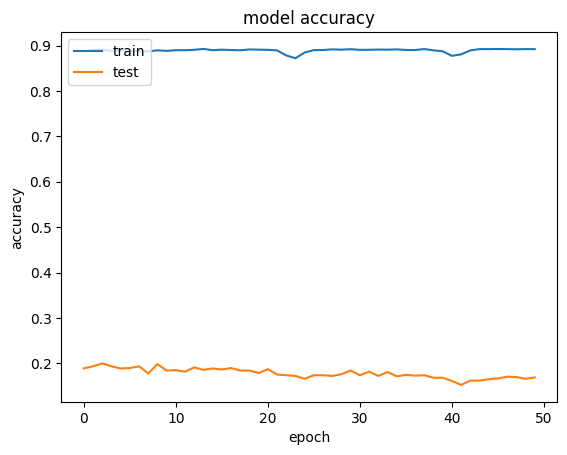

In [28]:
import matplotlib.pyplot as plt
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [29]:
from tensorflow.keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer
model = load_model('next_words.h5')
tokenizer = pickle.load(open('token.pkl', 'rb'))

def Predict_Next_Words(model, tokenizer, text):

  sequence = tokenizer.texts_to_sequences([text])
  sequence = np.array(sequence)
  preds = np.argmax(model.predict(sequence))
  predicted_word = ""
  
  for key, value in tokenizer.word_index.items():
      if value == preds:
          predicted_word = key
          break
  
  print(predicted_word)
  return predicted_word


while(True):
  
  text = input("Enter your line: ") 
  if text == "0":
      print("Execution completed.....")
      break
  
  else:
      try:
          text = text.split(" ")
          text = text[-3:]
          print(text)
        
          Predict_Next_Words(model, tokenizer, text)
          
      except Exception as e:
        print("Error occurred: ",e)
        continue
        

Enter your line: Gregor then turned to look out the
['look', 'out', 'the']
1/1 [==============================] - 1s 660ms/step
window
Enter your line: travelling salesmen live a life of
['a', 'life', 'of']
1/1 [==============================] - 0s 20ms/step
luxury
Enter your line: 0
Execution completed.....
